# **Object-Detection-From-Drone-For-Surveillance - Mask RCNN**

In [1]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.10.0

Cloning into 'vision'...
remote: Enumerating objects: 323074, done.
remote: Counting objects: 100% (1045/1045), done.
remote: Compressing objects: 100% (281/281), done.
remote: Total 323074 (delta 799), reused 983 (delta 755), pack-reused 322029
Receiving objects: 100% (323074/323074), 654.81 MiB | 32.37 MiB/s, done.
Resolving deltas: 100% (296845/296845), done.
fatal: not a git repository (or any of the parent directories): .git


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/MyDrive/VisDrone2019-DET-val.zip
!unzip -q /content/drive/MyDrive/VisDrone2019-DET-test-dev.zip

In [4]:
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

In [5]:
files_dir_train = '/content/VisDrone2019-DET-val/'
files_dir_test = '/content/VisDrone2019-DET-test-dev/'

### **Imports :** 

In [6]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

import sys
sys.path.append('/content/')

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor  

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler

torch.backends.cuda.matmul.allow_tf32 = False

print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu118
0.15.1+cu118


## **Visdrone Dataset Class**

In [7]:
class VisDroneDataset(torch.utils.data.Dataset):

    def __init__(self, img_dir,ann_dir, width, height, transforms=None):
        self.transforms = transforms
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(img_dir))
                        if image[-4:]=='.jpg']
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'pedestrian','people','bicycle', 
                        'car','van','truck','tricycle','awning-tricycle','bus','motor']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.img_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # dividing by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.txt'
        annot_file_path = os.path.join(self.ann_dir, annot_filename)
        
        boxes = []
        labels = []
        
        with open(annot_file_path, 'r') as f:
            for line in f:
                box = [float(x) for x in line.strip().split(',')]
                labels.append(int(box[5]))
                
                xmin, ymin, w, h = box[:4]
                xmax = xmin + w
                ymax = ymin + h
                xmin_corr = (xmin/img.shape[1])*self.width
                xmax_corr = (xmax/img.shape[1])*self.width
                ymin_corr = (ymin/img.shape[0])*self.height
                ymax_corr = (ymax/img.shape[0])*self.height
                boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)    
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["masks"] = torch.zeros((boxes.shape[0], self.height, self.width), dtype=torch.uint8)
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image=img_res, bboxes=target['boxes'], labels=labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
                      
        return img_res, target

    def __len__(self):
        return len(self.imgs)

## **Check Visdrone Dataset**


In [8]:
# check dataset
dataset_train = VisDroneDataset(files_dir_train+'/images',files_dir_train+'/annotations', 1224, 724)
dataset_test= VisDroneDataset('/content/images','/content/annotations', 1224, 724)

In [9]:
# getting the image and target for a test index
img1, target = dataset_train[1]
img, target = dataset_test[0]
print(img.shape, '\n',target)

(724, 1224, 3) 
 {'boxes': tensor([[6.1650e+02, 4.3819e+02, 7.1550e+02, 4.9970e+02],
        [5.2020e+02, 3.1042e+02, 5.5260e+02, 3.4638e+02],
        [5.5530e+02, 3.0947e+02, 5.8950e+02, 3.5112e+02],
        [5.9310e+02, 3.3124e+02, 6.7410e+02, 3.6910e+02],
        [6.8490e+02, 3.2746e+02, 7.2090e+02, 3.6910e+02],
        [7.2450e+02, 3.3124e+02, 7.5870e+02, 3.7004e+02],
        [7.6410e+02, 3.2746e+02, 8.0460e+02, 3.7194e+02],
        [8.0550e+02, 3.3030e+02, 8.4420e+02, 3.7194e+02],
        [7.9740e+02, 2.8108e+02, 8.3340e+02, 3.2178e+02],
        [7.2900e+02, 2.8865e+02, 7.9200e+02, 3.2651e+02],
        [7.2450e+02, 2.4228e+02, 7.6590e+02, 2.6878e+02],
        [7.0470e+02, 2.2146e+02, 7.6770e+02, 2.4701e+02],
        [3.9150e+02, 5.0633e+02, 5.1210e+02, 5.6027e+02],
        [4.3920e+02, 4.7983e+02, 5.4540e+02, 5.2904e+02],
        [4.4550e+02, 4.4765e+02, 5.5350e+02, 4.9118e+02],
        [4.5630e+02, 4.2304e+02, 5.5260e+02, 4.5901e+02],
        [4.2570e+02, 3.9938e+02, 5.1930e+02, 

## **Visualizing Bounding Boxes**

In [10]:
# Function to visualize bounding boxes in the image

def plot_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,15)
    a.imshow(img)
    label_names = {0: '', 1: 'pedestrian', 2: 'people', 3 : 'bicycle', 4: 'car', 5: 'van', 6: 'truck', 7: 'tricycle', 8: 'awning-tricycle', 9: 'bus', 10: 'motor', 11:''}
    for box, label in zip(target['boxes'], target['labels']):
      x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle((x, y), width, height,linewidth=1, edgecolor='b', facecolor='none')
      a.add_patch(rect)
      label_text = label_names[label.item()]
      a.text(x, y, f"{label_text}", color='r', fontsize=8)
    plt.show()

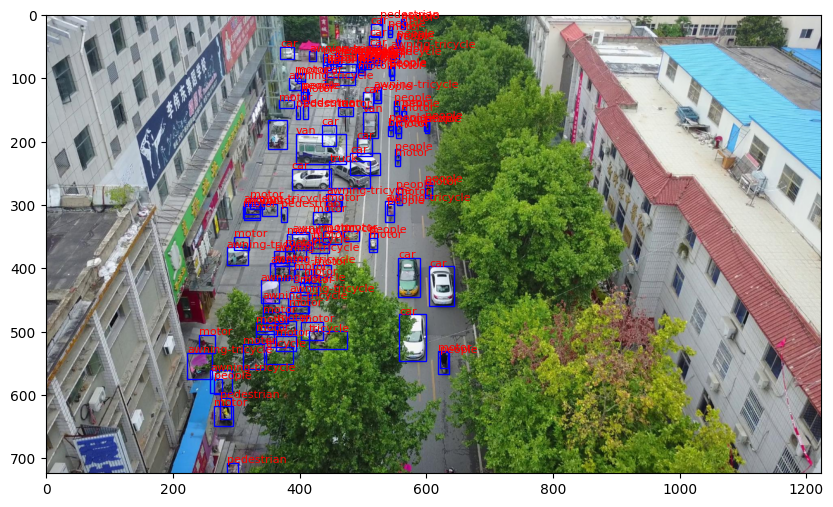

In [11]:
# plotting the image with bboxes.
img, target = dataset_train[0]
plot_bbox(img, target)

## **Object Detection Model**

In [13]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [14]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
      
    if train:
        return A.Compose([A.HorizontalFlip(0.5),ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## **Splitting Dataset**

In [15]:
# use our dataset and defined transformations
dataset_train = VisDroneDataset(files_dir_train+'/images',files_dir_train+'/annotations', 480, 480, transforms= get_transform(train=True))
dataset_test = VisDroneDataset('/content/images','/content/annotations', 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset_train)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset_train)*test_split)
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [16]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 12

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# Define the hyperparameters
lr = 0.005
momentum = 0.9
weight_decay = 0.0005
step_size = 3
gamma = 0.1

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr, momentum, weight_decay)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size,gamma)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 61.7MB/s]


## **Train and Evaluate Model**

In [17]:
import matplotlib.pyplot as plt

# initialize lists to store the metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# training for 2 epochs
num_epochs = 20

# initialize variables for early stopping
best_test_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    # training for one epoch
    metric_logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    train_loss = metric_logger.meters['loss'].avg
    train_accuracy = metric_logger.meters['accuracy'].avg
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # update the learning rate
    lr_scheduler.step()

     # evaluate on the test dataset after each epoch
    coco_evaluator = evaluate(model, data_loader_test, device=device)
    test_loss = coco_evaluator.coco_eval['bbox'].stats[0]
    test_accuracy = coco_evaluator.coco_eval['bbox'].stats[1]
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    # check if the current test loss is the best so far
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        counter = 0
    else:
        counter += 1
    
    # check if we should stop training early
    if counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

Epoch: [0]  [  0/439]  eta: 1:06:04  lr: 0.000016  loss: 7.1168 (7.1168)  loss_classifier: 2.8043 (2.8043)  loss_box_reg: 0.8410 (0.8410)  loss_mask: 1.6173 (1.6173)  loss_objectness: 1.6281 (1.6281)  loss_rpn_box_reg: 0.2261 (0.2261)  time: 9.0317  data: 0.4174  max mem: 1151
Epoch: [0]  [ 10/439]  eta: 0:07:40  lr: 0.000130  loss: 5.6319 (5.6484)  loss_classifier: 2.7451 (2.6820)  loss_box_reg: 0.6944 (0.7172)  loss_mask: 1.3374 (1.3324)  loss_objectness: 0.2739 (0.5074)  loss_rpn_box_reg: 0.3703 (0.4094)  time: 1.0731  data: 0.0470  max mem: 2369
Epoch: [0]  [ 20/439]  eta: 0:04:49  lr: 0.000244  loss: 4.1179 (4.5063)  loss_classifier: 2.1704 (2.1412)  loss_box_reg: 0.6944 (0.7208)  loss_mask: 0.8737 (0.8989)  loss_objectness: 0.2713 (0.3754)  loss_rpn_box_reg: 0.3550 (0.3700)  time: 0.2729  data: 0.0102  max mem: 2369
Epoch: [0]  [ 30/439]  eta: 0:03:48  lr: 0.000359  loss: 2.4646 (3.8158)  loss_classifier: 1.0944 (1.7851)  loss_box_reg: 0.7077 (0.7046)  loss_mask: 0.1065 (0.6259) 

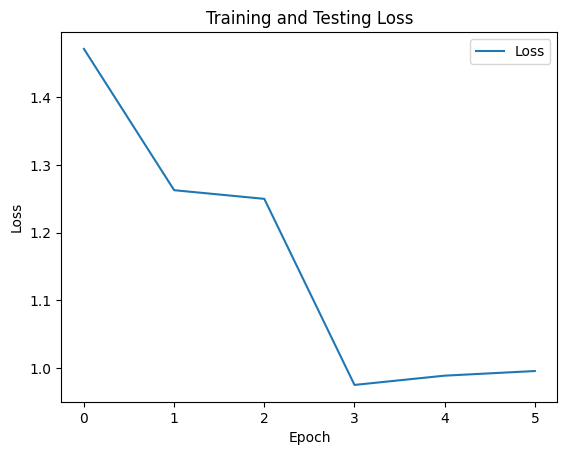

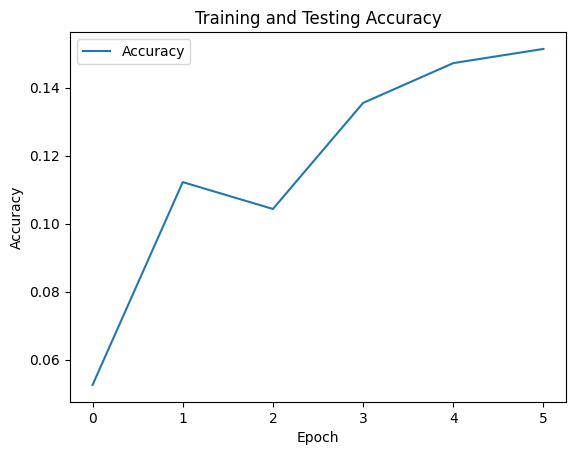

In [18]:
import matplotlib.pyplot as plt
# plot the metrics
plt.plot(train_losses, label='Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(test_accuracies, label='Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## **Non-Max Supression (NMS)**

In [19]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.1):   
    boxes = torch.Tensor(orig_prediction['boxes'])
    scores = torch.Tensor(orig_prediction['scores'])
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(boxes, scores, iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [20]:
import numpy as np
import torch

# Assuming that `img` is a numpy array with image data
img_tensor = torch.from_numpy(img).to(device)

## **Predicted Boxes vs Real Boxes**

In [21]:
model.eval()
with torch.no_grad():
    img_tensor = torch.from_numpy(img).to(device)
    img_tensor = img_tensor.permute(2, 0, 1)  # Permute the dimensions
    prediction = model([img_tensor])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  100
real #boxes:  128


## **Calculate Accuracy**

In [22]:
def calculate_iou(box1, box2):

    # Calculate the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # If the intersection is empty, return 0
    if x2 <= x1 or y2 <= y1:
        return 0.0

    # Calculate the area of intersection rectangle
    intersection_area = (x2 - x1) * (y2 - y1)

    # Calculate the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate the union area by subtracting the intersection area
    # and adding the areas of both bounding boxes
    union_area = box1_area + box2_area - intersection_area

    # Calculate the IoU by dividing the intersection area by the union area
    iou = intersection_area / union_area
    return iou

In [23]:
def calculate_map(prediction, target, iou_threshold=0.5):
    pred_labels = prediction['labels']
    true_labels = target['labels']
    matched_true_boxes = np.zeros(len(true_labels))
    matched_scores = np.zeros(len(pred_labels))
    for i, pred_box in enumerate(prediction['boxes']):
        for j, true_box in enumerate(target['boxes']):
            iou = calculate_iou(pred_box, true_box)
            if iou > iou_threshold and true_labels[j] == pred_labels[i]:
                matched_true_boxes[j] = 1
                matched_scores[i] = prediction['scores'][i]
    accuracy = np.sum(matched_true_boxes) / len(true_labels)
    return accuracy

EXPECTED OUTPUT ====> 


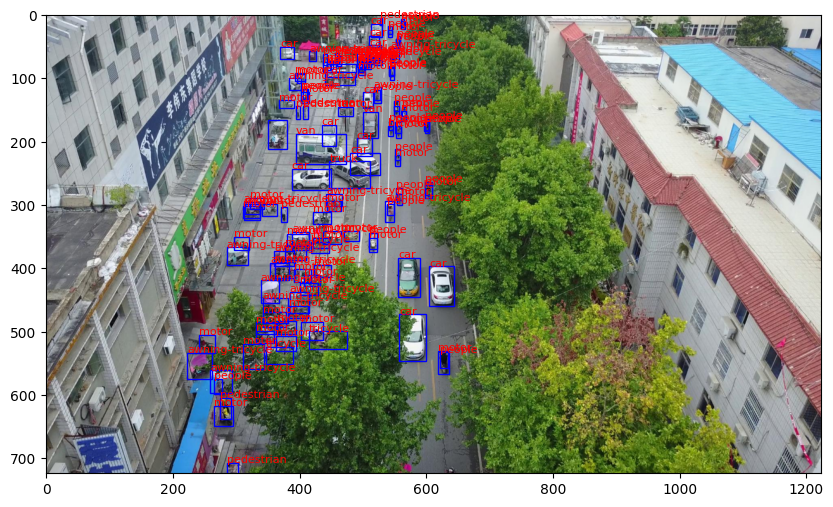

In [24]:
print('EXPECTED OUTPUT ====> ')
plot_bbox(torch_to_pil(img_tensor), target)

MODEL OUTPUT ====> 


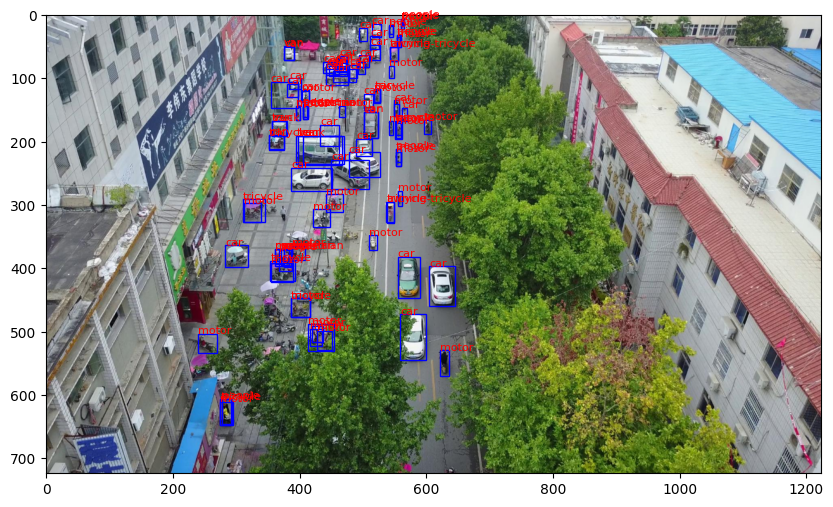

In [25]:
print('MODEL OUTPUT ====> ')
prediction_cpu = {k: v.cpu() for k, v in prediction.items()}
plot_bbox(torch_to_pil(img_tensor.cpu()), prediction_cpu)

NMS APPLIED OUTPUT ====> 


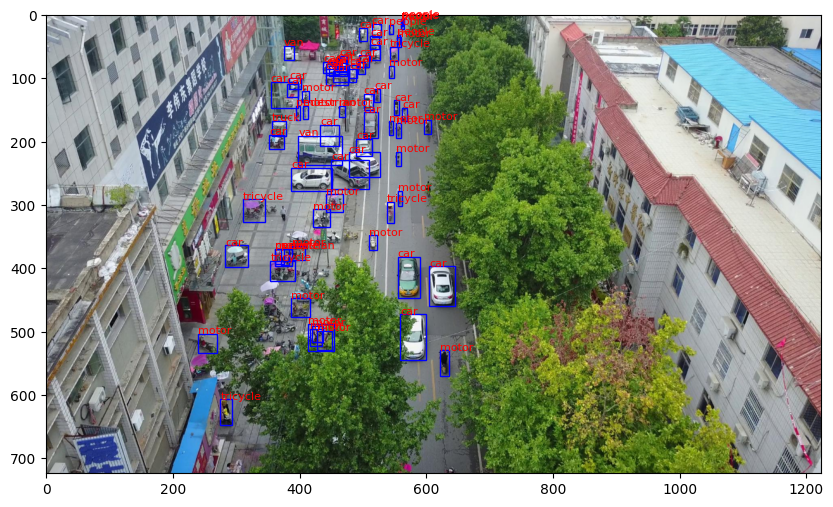

In [26]:
nms_prediction = apply_nms(prediction, iou_thresh=0.5)
nms_prediction_tensors = {k: torch.tensor(v) for k, v in nms_prediction.items()}
nms_prediction_cpu = {k: v.cpu().numpy() for k, v in nms_prediction_tensors.items()}
print('NMS APPLIED OUTPUT ====> ')
plot_bbox(torch_to_pil(img_tensor), nms_prediction_cpu)

## **Final Object Detection**

EXPECTED OUTPUT ====> 



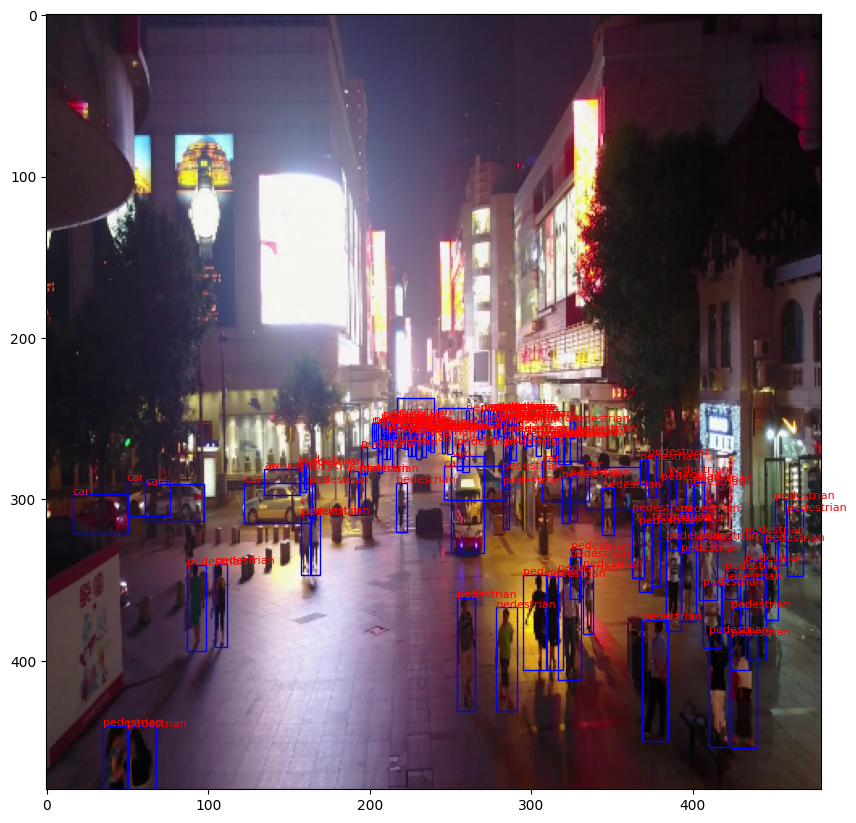

MODEL OUTPUT ====> 



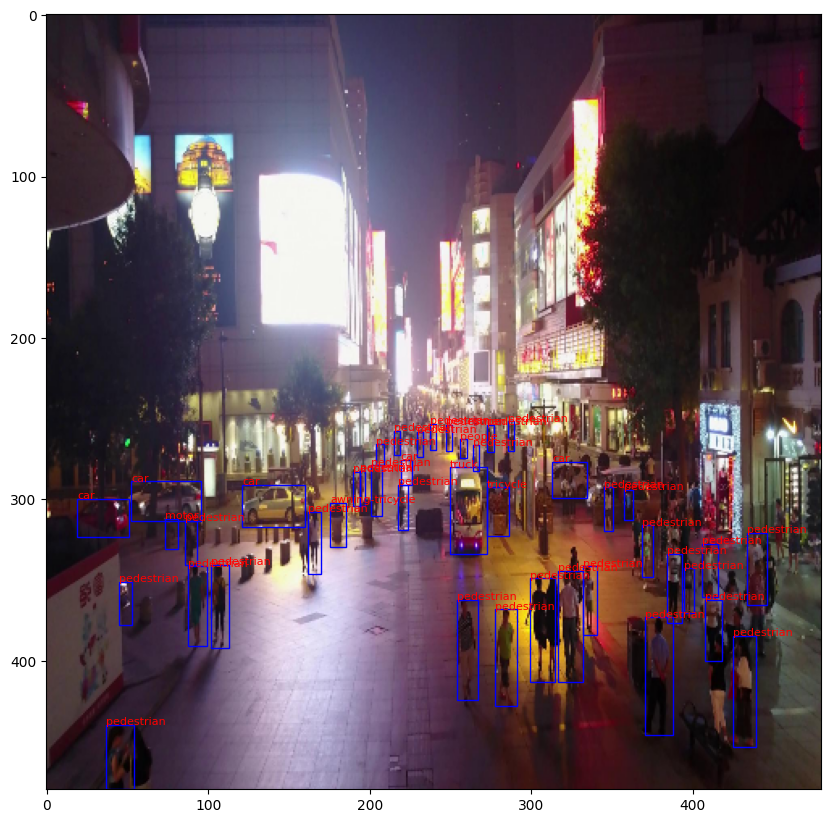

In [31]:
val_dataset = VisDroneDataset('/content/images','/content/annotations', 480, 480, transforms= get_transform(train=True))
# pick randome image from the val set
img, target = val_dataset[random.randint(0, len(val_dataset) - 1)]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT ====> \n')
plot_bbox(torch_to_pil(img), target)

print('MODEL OUTPUT ====> \n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)
nms_prediction_cpu = nms_prediction['boxes'].cpu().numpy()  # transfer the boxes tensor to CPU and convert it to a numpy array
nms_prediction['boxes'] = nms_prediction_cpu  # update the dictionary with the new numpy array

plot_bbox(torch_to_pil(img), nms_prediction)

In [32]:
mAP = calculate_map(nms_prediction, target, iou_threshold=0.5)
print('mAP ====> ', mAP)

mAP ====>  0.2
